
# Smart Home Energy Consumption — Carbon Emission Prediction

This notebook builds regression models to predict **carbon emissions** of a household using smart home energy data.

### Pipeline Outline
1. EDA & Visualization  
2. Data Cleaning & Encoding  
3. Train/Test/Validation Split  
4. Scaling  
5. Train 8–10 Regression Models  
6. Hyperparameter Tuning (RandomizedSearchCV)  
7. Evaluation on Test Data  
8. Model Comparison Plot


In [8]:

# ==========================
# Import Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor, ExtraTreesRegressor)

import warnings
warnings.filterwarnings('ignore')
print("✅ Libraries loaded")


✅ Libraries loaded


In [42]:

# ==========================
# Load Dataset
# ==========================
DATA_PATH = "smart_home_energy_consumption_large.csv"  # Update path if needed
EMISSION_FACTOR = 0.233  # kg CO₂ per kWh

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (100000, 8)


,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB
None
             Home ID  Energy Consumption (kWh)  Outdoor Temperature (°C)  \
count  100000.000000             100000.000000             100000.000000   
mean      250.374980                  1.499952                 14.950135   
std       144.435367                

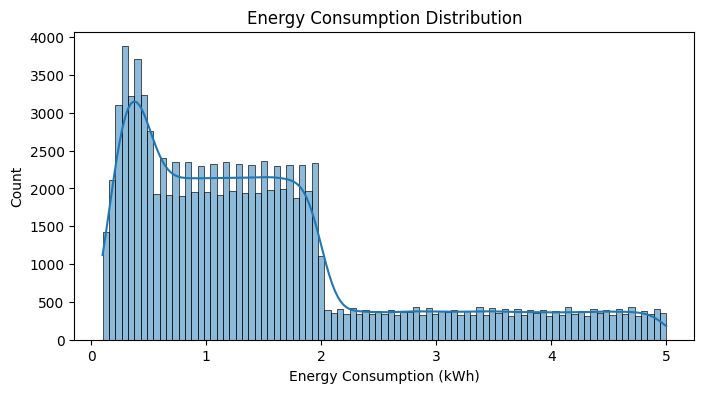

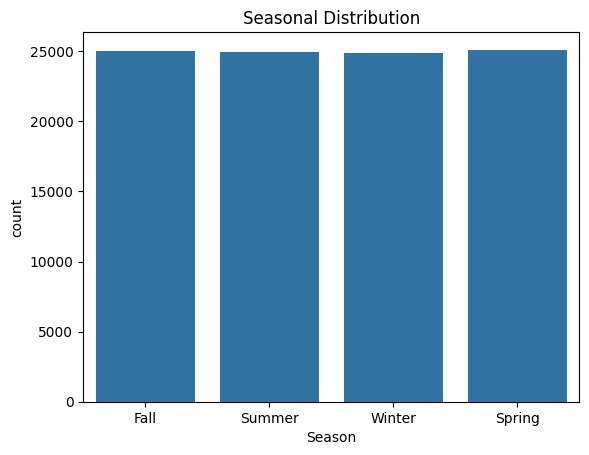

In [43]:

# ==========================
# EDA
# ==========================
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())

plt.figure(figsize=(8,4))
sns.histplot(df['Energy Consumption (kWh)'], kde=True)
plt.title("Energy Consumption Distribution")
plt.show()

sns.countplot(x='Season', data=df)
plt.title("Seasonal Distribution")
plt.show()


In [44]:

# ==========================
# Feature Engineering
# ==========================
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
df['Hour'] = df['Time'].dt.hour.astype(int)
df['Minute'] = df['Time'].dt.minute.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Weekday'] = df['Date'].dt.weekday.astype(int)

df['Carbon Emission (kgCO2)'] = df['Energy Consumption (kWh)'] * EMISSION_FACTOR
df.drop(columns=['Home ID', 'Date', 'Time'], inplace=True)

print("Feature engineering complete")
df.head()


Feature engineering complete


,Appliance Type,Energy Consumption (kWh),Outdoor Temperature (°C),Season,Household Size,Hour,Minute,Month,Weekday,Carbon Emission (kgCO2)
0,Fridge,0.20,-1.0,Fall,2,21,12,12,5,0.04660
1,Oven,0.23,31.1,Summer,5,20,11,8,6,0.05359
2,Dishwasher,0.32,21.3,Fall,3,6,39,11,1,0.07456
3,Heater,3.92,-4.2,Winter,1,21,56,1,5,0.91336
4,Microwave,0.44,34.5,Summer,5,4,31,8,5,0.10252


In [45]:

# ==========================
# Encode Categorical Data
# ==========================
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

print("Categorical columns encoded:", list(cat_cols))
df.head()


Categorical columns encoded: ['Appliance Type', 'Season']


,Appliance Type,Energy Consumption (kWh),Outdoor Temperature (°C),Season,Household Size,Hour,Minute,Month,Weekday,Carbon Emission (kgCO2)
0,3,0.20,-1.0,0,2,21,12,12,5,0.04660
1,7,0.23,31.1,2,5,20,11,8,6,0.05359
2,2,0.32,21.3,0,3,6,39,11,1,0.07456
3,4,3.92,-4.2,3,1,21,56,1,5,0.91336
4,6,0.44,34.5,2,5,4,31,8,5,0.10252


In [46]:

# ==========================
# Split Data
# ==========================
X = df.drop(columns=['Carbon Emission (kgCO2)', 'Energy Consumption (kWh)'])
y = df['Carbon Emission (kgCO2)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (70000, 8), Validation: (15000, 8), Test: (15000, 8)


In [47]:

# ==========================
# Scale Data
# ==========================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
print("✅ Scaling complete")


✅ Scaling complete


In [48]:

# ==========================
# Train Multiple Models
# ==========================
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    preds = model.predict(X_val_s)
    results[name] = {
        "RMSE": mean_squared_error(y_val, preds),
        "MAE": mean_absolute_error(y_val, preds),
        "R2": r2_score(y_val, preds)
    }

results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
results_df


,RMSE,MAE,R2
GradientBoosting,0.018558,0.111124,0.756242
RandomForest,0.019501,0.112834,0.743849
ExtraTrees,0.020255,0.114204,0.733951
AdaBoost,0.020830,0.123723,0.726394
DecisionTree,0.037544,0.148381,0.506855
LinearRegression,0.068209,0.202805,0.104069
Ridge,0.068209,0.202805,0.104069
Lasso,0.076133,0.209353,-0.000017
ElasticNet,0.076133,0.209353,-0.000017


In [50]:

# ==========================
# Hyperparameter Tuning (RandomForest)
# ==========================
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, 
                               scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(X_train_s, y_train)
print("Best Params:", rf_search.best_params_)
print("Best RMSE:", -rf_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Best RMSE: 0.13610243949741088


In [51]:

# ==========================
# Evaluate on Test Data
# ==========================
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test_s)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}\nTest MAE: {mae:.3f}\nTest R²: {r2:.3f}")


Test RMSE: 0.018
Test MAE: 0.111
Test R²: 0.756


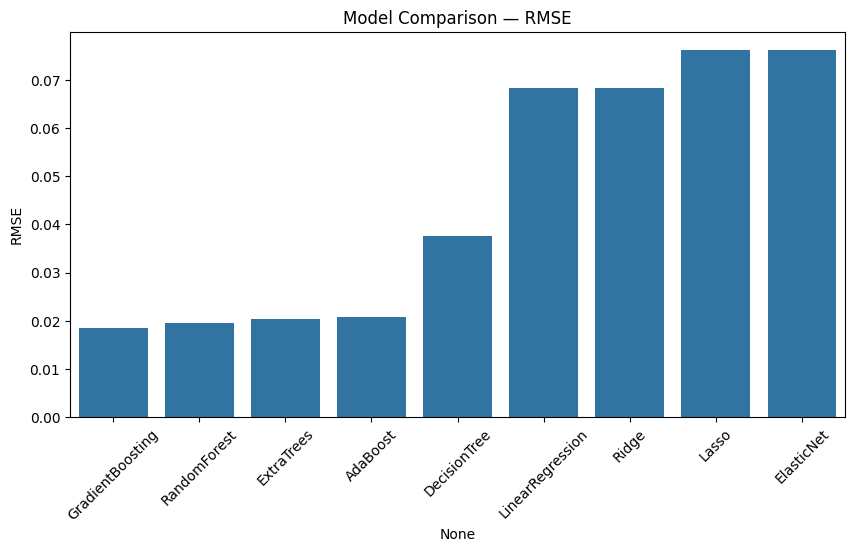

In [52]:

# ==========================
# Model Comparison Plot
# ==========================
plt.figure(figsize=(10,5))
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.xticks(rotation=45)
plt.title("Model Comparison — RMSE")
plt.show()
